In [1]:
# Google Colab specific code for mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

# # Define the directory path on your Google Drive
# # Replace 'Your_directory' with the actual directory
# directory = '/content/drive/My Drive/Colab Notebooks/ML4GST/'

# # Now use this directory for reading and writing data
# data_template_filename = directory + "dataset.txt"
# gst_dir = directory + "test_gst_dir"

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/ML4GST

/content/drive/MyDrive/Colab Notebooks/ML4GST


In [ ]:
pip install pygsti

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 93.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygsti: filename=pyGSTi-0.9.11.1-cp310-cp310-linux_x86_64.whl size=16637189 sha256=6048426155e400d7d7b7a4d1060a962126c7a015205f651ecf73ea4d67168faf
  Stored in directory: /root/.cache/pip/wheels/0c/e2/66/a0b57654bd57deac92b450f0e8969fe7021fab78e556a15d23
Successfully built pygsti


In [ ]:
import pygsti
import pygsti.algorithms.fiducialselection as fidsel
import pygsti.algorithms.germselection as germsel
import numpy as np
import pandas as pd

# Define the Pauli Transfer Matrices for the gates
# I = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
# X_pi_4 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, np.cos(np.pi/4), -np.sin(np.pi/4)], [0, 0, np.sin(np.pi/4), np.cos(np.pi/4)]])
# Y_pi_2 = np.array([[1, 0, 0, 0], [0, np.cos(np.pi/2), 0, np.sin(np.pi/2)], [0, 0, 1, 0], [0, -np.sin(np.pi/2), 0, np.cos(np.pi/2)]])

# Create the explicit model
target_model = pygsti.models.create_explicit_model_from_expressions(
    [('Q0',)], ['Gi', 'Gx', 'Gy'],
    ["I(Q0)", "X(pi/4,Q0)", "Y(pi/2,Q0)"])

# Automatic selection of fiducials and germs using "laissez-faire" method
prepFiducials, measFiducials = fidsel.find_fiducials(target_model)
germs = germsel.find_germs(target_model, seed = 1234)

# Generate a list of circuits using the long-sequence gate set tomography (LSGST) method
maxLengths = [2**n for n in range(5)]
listOfExperiments = pygsti.circuits.create_lsgst_circuits(
    target_model, prepFiducials, measFiducials, germs, maxLengths)

# Simulate the probability outcomes of these circuits
ds = pygsti.data.simulate_data(target_model, listOfExperiments, num_samples=1000,
                                            sample_error="binomial", seed=1234)
# print(ds)

pygsti.io.write_dataset("Custom_1Q_XYI_dataset.txt", ds, outcome_label_order=['0','1'])

# Convert the probabilities to a DataFrame and save to a CSV file




Initial Length Available Fiducial List: 7
Length Available Fiducial List Dropped Identities and Duplicates: 7
Using GRASP algorithm.
Preparation fiducials:
['{}', 'GyGy', 'GxGx', 'Gy']
Score: 32.0
Measurement fiducials:
['{}', 'Gy', 'GxGx']
Score: 9.999999999999996
Initial Length Available Germ List: 196
Length Available Germ List After Deduping: 59
Length Available Germ List After Dropping Random Fraction: 59
Length Available Germ List After Adding Back In Forced Germs: 59
Memory estimate of 0.0 GB for all-Jac mode.
Memory estimate of 0.0 GB for single-Jac mode.
Using greedy algorithm.
Constructed germ set:
['Gi', 'Gx', 'Gy', 'GxGxGy', 'GiGxGx', 'GiGyGx', 'GiGyGxGxGyGy', 'GiGyGyGyGxGx', 'GxGxGyGxGyGy', 'GiGxGyGyGyGx']
Score: major=-34.0 minor=711.6500383006758, N: 34


In [3]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

# Load data
df = pd.read_csv('Encoded_Padded_Probabilities.csv')

# Split data into features (X) and labels (y)
X = df['Padded'].apply(lambda x: [int(xi) for xi in x.rstrip(',').split(',')]).to_list()
y = df[['Prob_1', 'Prob_2']].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [4]:
# Define model
model = Sequential([
    Dense(128, activation='relu', input_shape=(len(X_train[0]),)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid function outputs in the range [0, 1]
])

# Scale model output to range [0, 2pi]
scaling_layer = Lambda(lambda x: x * 2 * math.pi)
model.add(scaling_layer)

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Lists to record losses
train_losses = []
val_losses = []

# Define gate application function
def apply_gate(state, theta_value, label):
    # Construct arrays using NumPy
    # Define gates in PTM form
    I_np = np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]], dtype=np.float32)  #Gi

    Y_pi_2_np = np.array([[1, 0, 0, 0],
                          [0, np.cos(np.pi/2), 0, np.sin(np.pi/2)],
                          [0, 0, 1, 0],
                          [0, -np.sin(np.pi/2), 0, np.cos(np.pi/2)]], dtype=np.float32) #Gy

    # Normalized State corresponding to |0⟩ in Pauli basis
    # state_np = np.array([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)], dtype=np.float32)

    # Convert NumPy arrays to TensorFlow tensors
    I = tf.convert_to_tensor(I_np)
    Y_pi_2 = tf.convert_to_tensor(Y_pi_2_np)
    # state = tf.convert_to_tensor(state_np)

    X_theta = tf.convert_to_tensor([[1, 0, 0, 0], [0, tf.math.cos(theta_value), 0, tf.math.sin(theta_value)],
                           [0, 0, 1, 0], [0, -tf.math.sin(theta_value), 0, tf.math.cos(theta_value)]], dtype=tf.float32)  # Gx
    # print('current label: ', label)

    if label == 1:
        return tf.linalg.matmul(X_theta, tf.reshape(state, [-1, 1]))
    elif label == 2:
        return tf.linalg.matmul(Y_pi_2, tf.reshape(state, [-1, 1]))
    elif label == 3:
        return tf.linalg.matmul(I, tf.reshape(state, [-1, 1]))
    else:
        return state  # If label is 0, don't apply any gate


def apply_gate_sequence(single_gate_sequence):
    # Initialize state in Pauli basis
    state = tf.convert_to_tensor([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)], dtype=tf.float32)

  # Apply each gate in the sequence
    theta_value = model(single_gate_sequence[tf.newaxis, :]) # Predict theta for the current gate
    # print('theta_value: ', theta_value)
    theta_value = tf.squeeze(theta_value)
    # print('squeezed theta_value: ', theta_value)
    for i in range(tf.shape(single_gate_sequence)[0]):
      if single_gate_sequence[i] == 0:
        break
      # print('tf.shape(single_gate_sequence): ', tf.shape(single_gate_sequence))
      # print('tf.shape(single_gate_sequence[0]): ', tf.shape(single_gate_sequence)[0])
      # print('single_gate_sequence[i]: ', single_gate_sequence[i])
      state = apply_gate(state, theta_value, single_gate_sequence[i])
      # print('current state: ', state)

    return state


def compute_probabilities(ptm_vector):
    # PTM representations for |0> and |1> states
    ptm_0 = tf.constant([1, 0, 0, 1], dtype=tf.float32)
    ptm_1 = tf.constant([1, 0, 0, -1], dtype=tf.float32)
    # ptm_0 = tf.convert_to_tensor([1, 0, 0, 1], dtype=tf.float32)
    # ptm_1 = tf.convert_to_tensor([1, 0, 0, -1], dtype=tf.float32)

    # Normalize the vectors
    ptm_vector = tf.squeeze(tf.linalg.l2_normalize(ptm_vector))
    ptm_0 = tf.linalg.l2_normalize(ptm_0)
    ptm_1 = tf.linalg.l2_normalize(ptm_1)

    # Compute dot products
    prob_0 = tf.tensordot(ptm_vector, ptm_0, axes=1)
    prob_1 = tf.tensordot(ptm_vector, ptm_1, axes=1)

    return tf.stack([prob_0, prob_1])


# Define loss function
loss_fn = MeanSquaredError()

# Define optimizer
optimizer = Adam()

# Define training loop
def train_step(X, y):
    with tf.GradientTape() as tape:
      batched_final_states = []
      batched_probabilities = []

      # Process each sequence in the batch individually
      for i in range(tf.shape(X)[0]):
          single_sequence = tf.gather(X, i, axis=0)
          final_state = apply_gate_sequence(single_sequence)
          probabilities = compute_probabilities(final_state)
          batched_final_states.append(final_state)
          # print('batched_final_states: ', batched_final_states)
          batched_probabilities.append(probabilities)
          # print('batched_probabilities: ', batched_probabilities)

      batched_final_states = tf.stack(batched_final_states)
      # print('batched_final_states: ', batched_final_states)
      # print('batched_final_states.shape: ', batched_final_states.shape)
      batched_probabilities = tf.stack(batched_probabilities)
      # print('batched_probabilities: ', batched_probabilities)
      # print('batched_probabilities.shape: ', batched_probabilities.shape)


      loss = loss_fn(y, batched_probabilities)
      # print('loss: ', loss)

    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss


# Define validation loop (similar to training loop but without gradients)
def validate_step(X, y, print_results = False):
    batched_final_states = []
    batched_probabilities = []
    batched_thetas = []

    for i in range(tf.shape(X)[0]):
        single_sequence = tf.gather(X, i, axis=0)
        final_state = apply_gate_sequence(single_sequence)
        probabilities = compute_probabilities(final_state)
        batched_final_states.append(final_state)
        batched_probabilities.append(probabilities)
        if print_results == True:
            theta_value = model(single_sequence[tf.newaxis, :]) # Predict theta for the current gate
            theta_value = tf.squeeze(theta_value)
            batched_thetas.append(theta_value)

    batched_final_states = tf.stack(batched_final_states)
    batched_probabilities = tf.stack(batched_probabilities)
    loss = loss_fn(y, batched_probabilities)
    if print_results == True:
      print('batched_thetas: ', batched_thetas)
    return loss

In [ ]:
# Training loop
EPOCHS = 50
BATCH_SIZE = 32
for epoch in range(EPOCHS):  # Number of epochs
    for i in range(0, len(X_train), BATCH_SIZE):  # Batch size
        X_batch = X_train[i:i+BATCH_SIZE]
        y_batch = y_train[i:i+BATCH_SIZE]

        # print('X_batch.shape: ', X_batch.shape)
        # print('y_batch.shape: ', y_batch.shape)

    train_loss = train_step(X_train, y_train)
    val_loss = validate_step(X_test, y_test)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss.numpy()}, Validation Loss: {val_loss.numpy()}")

Epoch: 1, Train Loss: 0.17836721241474152, Validation Loss: 0.1889510601758957
Epoch: 2, Train Loss: 0.17375397682189941, Validation Loss: 0.15689390897750854
Epoch: 3, Train Loss: 0.16397175192832947, Validation Loss: 0.18113498389720917
Epoch: 4, Train Loss: 0.14897491037845612, Validation Loss: 0.18449343740940094
Epoch: 5, Train Loss: 0.1475483924150467, Validation Loss: 0.17349189519882202
Epoch: 6, Train Loss: 0.14036546647548676, Validation Loss: 0.16169938445091248
Epoch: 7, Train Loss: 0.13657544553279877, Validation Loss: 0.16672584414482117
Epoch: 8, Train Loss: 0.12948285043239594, Validation Loss: 0.17110013961791992
Epoch: 9, Train Loss: 0.12643134593963623, Validation Loss: 0.1736517995595932
Epoch: 10, Train Loss: 0.11998146027326584, Validation Loss: 0.17011892795562744
Epoch: 11, Train Loss: 0.11637027561664581, Validation Loss: 0.17585258185863495
Epoch: 12, Train Loss: 0.11237902194261551, Validation Loss: 0.17740531265735626
Epoch: 13, Train Loss: 0.109090037643909

In [ ]:
model.save('my_model.h5')

In [5]:
model = tf.keras.models.load_model('my_model.h5')

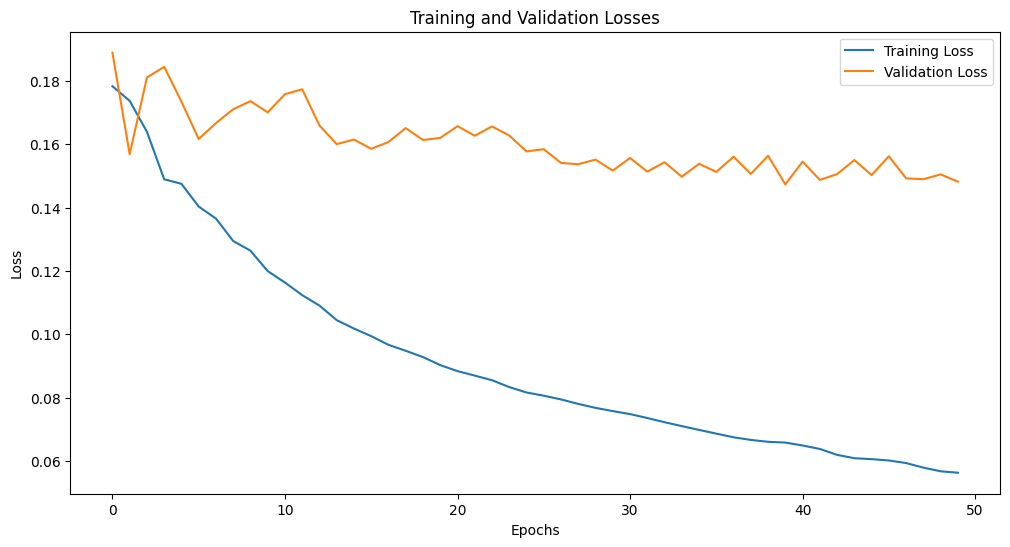

In [ ]:
# Plotting training and validation losses
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [ ]:
# Convert the recorded losses into a DataFrame
loss_df = pd.DataFrame({
    'Epoch': list(range(1, EPOCHS + 1)),
    'Training_Loss': train_losses,
    'Validation_Loss': val_losses
})

# Save the DataFrame to a CSV file
loss_df.to_csv('losses.csv', index=False)


In [6]:
# Function to sample part of the training data and evaluate model's performance
def sample_and_evaluate(num_samples=10):
    indices = np.random.choice(len(X_train), size=num_samples, replace=False)
    sampled_X = X_train[indices]
    sampled_y = y_train[indices]
    loss = validate_step(sampled_X, sampled_y, print_results = True)
    print(f"Loss on sampled data: {loss.numpy()}")
    return loss.numpy()

In [7]:
sample_and_evaluate()

batched_thetas:  [<tf.Tensor: shape=(), dtype=float32, numpy=3.0566976>, <tf.Tensor: shape=(), dtype=float32, numpy=2.12268>, <tf.Tensor: shape=(), dtype=float32, numpy=2.6691968>, <tf.Tensor: shape=(), dtype=float32, numpy=2.744393>, <tf.Tensor: shape=(), dtype=float32, numpy=2.7874644>, <tf.Tensor: shape=(), dtype=float32, numpy=2.9792786>, <tf.Tensor: shape=(), dtype=float32, numpy=2.5224917>, <tf.Tensor: shape=(), dtype=float32, numpy=3.0041747>, <tf.Tensor: shape=(), dtype=float32, numpy=3.87111>, <tf.Tensor: shape=(), dtype=float32, numpy=2.1856716>]
Loss on sampled data: 0.06953456252813339


0.06953456

In [ ]:
tf.shape(X_train)[0]

<tf.Tensor: shape=(), dtype=int32, numpy=272>

In [ ]:
apply_gate(np.array([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)], dtype=np.float32), 0.5, 0)

current label:  0


array([0.70710677, 0.        , 0.        , 0.70710677], dtype=float32)

In [ ]:
test_vector = np.array(
    [[ 0.70710677],
     [-0.7064972 ],
     [ 0.        ],
     [-0.02935636]], dtype=np.float32)

In [ ]:
test_vector.shape

(4, 1)

In [ ]:
tf.squeeze(test_vector).shape

TensorShape([4])

In [ ]:
compute_probabilities(tf.constant([1, 0, 0, 1], dtype=tf.float32))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.99999994>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)

In [ ]:
compute_probabilities(tf.constant([1, 0, 0, -1], dtype=tf.float32))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.99999994>)

In [ ]:
# for i in range (tf.shape(X_train[:1])[0]):
#   single_sequence = tf.gather(X_train, i, axis=0)
#   print('single_sequence: ', single_sequence)
#   final_state = apply_gate_sequence(single_sequence)
#   print('final_state: ', final_state)
#   probabilities = compute_probabilities(final_state)
#   print('probabilities: ',probabilities )

In [ ]:
len(X_train[0])

20

In [ ]:
debug = tf.convert_to_tensor([[1, 0, 0, 0], [0, tf.math.cos(0.5), 0, tf.math.sin(0.5)],
                           [0, 0, 1, 0], [0, -tf.math.sin(0.5), 0, tf.math.cos(0.5)]], dtype=tf.float32)

In [ ]:
debug

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.87758255,  0.        ,  0.47942555],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        , -0.47942555,  0.        ,  0.87758255]],
      dtype=float32)>